In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolor

This is the code used to generate the figure illustrating the performance of different scheduling approaches (Fig. 1).
As input it requires a dataset containing several particles in the order in which their simulation was started with their acceptance status and simulation time.
It can assign the simulation of the particles to the workers by itself, following the idea of either STAT, DYN or LA.

If the information about the particles is available it could plot the development of any population.

In [2]:
def Insert_row_(row_number, df, row_value): 
    """inserts an additional row at a specific location in a dataframe
    """
    # Slice the upper half of the dataframe 
    df1 = df[0:row_number] 
   
    # Store the result of lower half of the dataframe 
    df2 = df[row_number:] 
   
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
   
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
   
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 

def assign_workers(testdata: pd.DataFrame,
                   isPPP: bool,
                   Nworkers: int,
                   Ngenerations: int,
                   Nacceptances: int):
    """Assign the particle simulations to the workers.
    
    Parameters
    ----------
    
    isPPP: 
        The scheduling approach to be used.
        False --> Dynamic Scheduling
        True --> Look-Ahead Scheduling
    Nworkers:
        Number of available workers
    Ngenerations:
        Number of generations
    Nacceptances:
        Number of acceptances per generation
    
    """
    
    
    current_gen=0
    workerclocks = np.zeros(Nworkers)
    current_acceptances = 0
    t_no_new_samples = np.inf
    i=0
    
    indexworkercol=testdata.columns.get_loc('Worker #')
    indexstatuscol=testdata.columns.get_loc('Status')
    indexdurationcol=testdata.columns.get_loc('Duration (ms)')

    while i < len(testdata):
        
        #check if new generation started
        if testdata['Generation'].iloc[i] != current_gen:
            current_gen=testdata['Generation'].iloc[i]
            current_acceptances=0
            t_no_new_samples=np.inf
            
            #insert wait times between generations
            if not isPPP and current_gen != Ngenerations+1 and current_gen != 1:
                new_gen_starttime = workerclocks.max()
                for k in range(Nworkers):
                    if k !=workerclocks.argmax():
                        row_value = [i, current_gen, "None", k + 1, new_gen_starttime-workerclocks[k]]
                        testdata=Insert_row_(i, testdata, row_value)
                        workerclocks[k]=new_gen_starttime
                        i += 1

        if workerclocks.min() >= t_no_new_samples:
            testdata.iloc[i,indexstatuscol]="None"
            testdata.iloc[i, indexdurationcol]=0
        else:
            #assign worker            
            freeworker = workerclocks.argmin() + 1
            testdata.iloc[i, indexworkercol] = freeworker
            workerclocks[freeworker - 1] += testdata.iloc[i, indexdurationcol]

            #check acceptance

            if testdata['Status'].iloc[i] == "Accepted":
                if current_acceptances < Nacceptances:
                    current_acceptances += 1
                    if current_acceptances == Nacceptances:
                        t_no_new_samples = workerclocks[freeworker - 1]

                else:
                    testdata.iloc[i,indexstatuscol]="Discarded"
                    t_no_new_samples=min(t_no_new_samples, workerclocks[freeworker - 1])

        i += 1
    
    endtime=workerclocks.max()
    
    return testdata

In [3]:
def find_walltimes(testdata: pd.DataFrame, 
                   Nworkers: int, 
                   Ngenerations: int):
    
    walltimes = np.zeros((Ngenerations+1,Nworkers))
    processes = np.zeros(Nworkers)
    
    for i in range(0, Nworkers):
        for j in range(1, Ngenerations+1):
            testdata_worker = testdata.loc[testdata['Worker #']==i+1]
            testdata_worker_gen = testdata_worker.loc[testdata_worker['Generation']==j]
            testdata_worker_gen = testdata_worker_gen.assign(
                Walltime=lambda testdata_worker: testdata_worker_gen['Duration (ms)'].cumsum())
            walltimes[j,i] = walltimes[j-1,i]+testdata_worker_gen.tail(1)['Walltime']
            processes[i] = len(testdata_worker)
    return walltimes, processes


def create_arrays(testdata: pd.DataFrame, 
                  Nworkers: int,
                  Ngenerations: int, 
                  Nmax_proc: int):
    
    """Takes the dataframe 
    and returns some arrays which sort the particles of each worker in one column
    """
    
    runtimes_wp = np.zeros((int(Nmax_proc), Nworkers))
    generations_wp = np.zeros((int(Nmax_proc), Nworkers))
    acceptance_wp = [[None for x in range(Nworkers)] for y in range(int(Nmax_proc))]

    for i in range(0,Nworkers):
        testdata_worker = testdata.loc[testdata['Worker #']==i+1]
        runtimes = testdata_worker['Duration (ms)'].values
        generations = testdata_worker['Generation'].values
        acceptance = testdata_worker['Status'].array
        for j in range(len(runtimes)):
            runtimes_wp[j,i]=runtimes[j]
            generations_wp[j,i]=generations[j]
            acceptance_wp[j][i] = acceptance[j]
    return runtimes_wp, generations_wp, acceptance_wp


def create_colortable(color: dict, 
                     generations_wp: np.array,
                     acceptance_wp: np.array,
                     Nworkers: int, 
                     Nmax_proc: int):
    """uses the above arrays to create a new one
    containing colors in order to plot this
    """
    colortable = [[None for x in range(Nworkers)] for y in range(int(Nmax_proc))]

    for i in range(Nworkers):
        for j in range(int(Nmax_proc)):
            colortable[j][i]=color[str(int(generations_wp[j,i]))+str(acceptance_wp[j][i])]
    return colortable

In [40]:
def draw_picture(ax,
                 colordict: dict, 
                 colortable: list, 
                 runtimes_wp: np.array,
                 walltimes: np.array,
                 Nworkers: int, 
                 Ngenerations: int, 
                 Nmax_proc: int, 
                 isPPP: bool,
                 y_max: int=0,
                 legend: bool=False,
                 title: str=None):

    """plots the colortable as a barplot
    """
    
    index = np.arange(Nworkers)+1
    bar_width = 0.7
    y_offset = np.zeros(Nworkers)
    
    if y_max == 0:
        y_max=walltimes.max()    
    for row in range(int(Nmax_proc)):
        ax.bar(index, runtimes_wp[row]-10, bar_width, bottom=y_offset, color = colortable[row])
        y_offset = y_offset + runtimes_wp[row]

    for gen in range(1,Ngenerations+1):
        if isPPP:
            start_time = walltimes[gen,:].min()
            plt.axhline(start_time, linestyle='dashed', color ='black')
        end_time = walltimes[gen,:].max()
        ax.axhline(end_time, color = 'black')
    
    if Ngenerations==1:
        final_time=walltimes[1,:].max()
        ax.axhline(final_time, color = 'black')
    ax.set_xticks(index)
    ax.set_xlabel("Worker")
    ax.set_ylabel("Time")
    ax.set_ylim(0,y_max)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if title != None:
        ax.set_xlabel("Worker \n"+str(title))
    
    
    if legend:
        plt.bar([1],[1],0, color = colordict["1Accepted"], label="Accepted")
        plt.bar([1],[1],0, color = colordict["1Rejected"], label="Discarded")
        plt.plot([1],[1], color='black', label="End of generation")
        plt.legend()
   
    return ax

In [5]:
def generate_picture(ax,
                     testdata_source: pd.DataFrame, 
                     colordict: dict, 
                     isPPP: bool,
                     draw_source: bool,
                     Nacceptances: int, 
                     Nworkers: int,
                     y_max: int = 0,
                     legend: bool = False,
                     title: str = None):
    """calls each function in the right order.
    I.e. reads data, transforms it and draws the picture"""
    Ngenerations = int(testdata_source['Generation'].max())    
    
    if draw_source:
        testdata=testdata_source
    else:
        testdata = assign_workers(testdata_source, isPPP, Nworkers, Ngenerations, Nacceptances)
    
    if Nworkers==0:
        Nworkers = int(testdata['Worker #'].max())
        
    walltimes, processes = find_walltimes(testdata, Nworkers, Ngenerations)
    
    Nmax_proc = int(processes.max())
    
    runtimes_wp, generations_wp, acceptance_wp = create_arrays(testdata, Nworkers, Ngenerations, Nmax_proc)
    
    colortable = create_colortable(colordict, generations_wp, acceptance_wp, Nworkers, Nmax_proc)
    
    myax = draw_picture(ax, colordict, colortable, runtimes_wp, walltimes, Nworkers, Ngenerations, Nmax_proc,
                        isPPP, y_max=y_max, legend=legend, title=title)
    return myax

In [6]:
def assign_static(testdata: pd.DataFrame,
                   Nworkers: int,
                   Ngenerations: int,
                   Nacceptances: int):
    """same as assign_worker but with static scheduling
    """
    
    current_gen=0
    workerclocks = np.zeros(Nworkers)
    current_acceptances = 0
    
    i=0
    
    indexworkercol=testdata_source.columns.get_loc('Worker #')
    indexstatuscol=testdata_source.columns.get_loc('Status')
    indexdurationcol=testdata_source.columns.get_loc('Duration (ms)')
    while i < len(testdata):

        #check if new generation started
        if testdata['Generation'].iloc[i] != current_gen:
            current_gen=testdata['Generation'].iloc[i]
            current_acceptances=0
            
            if current_gen != Ngenerations+1 and current_gen != 1:
                    new_gen_starttime = workerclocks.max()
                    for k in range(Nworkers):
                        if k !=workerclocks.argmax():
                            row_value = [i, current_gen, "None", k + 1, new_gen_starttime-workerclocks[k]]
                            testdata=Insert_row_(i, testdata, row_value)
                            workerclocks[k]=new_gen_starttime
                            i += 1

        freeworker = workerclocks.argmin() + 1
        
        if current_acceptances < Nacceptances:

            while testdata.iloc[i, indexstatuscol]== "Rejected":
                workerclocks[freeworker - 1] += testdata.iloc[i, indexdurationcol]
                testdata.iloc[i, indexworkercol] = freeworker
                i+=1

            testdata.iloc[i, indexworkercol] = freeworker
            workerclocks[freeworker - 1] += testdata.iloc[i, indexdurationcol]
        
            current_acceptances += 1
            
        else:
            testdata.iloc[i,indexstatuscol]="None"
            testdata.iloc[i, indexdurationcol]=0
        i += 1
    
    return testdata

def generate_static(ax,
                    testdata_source: pd.DataFrame, 
                     colordict: dict, 
                     isPPP: bool, 
                     draw_source: bool,
                     Nacceptances: int, 
                     Nworkers: int,
                     y_max: int=0,
                     legend: bool = False,
                     title: str = None):
    """same as generate picture but using STAT"""
    testdata_source = testdata_source.copy()
    Ngenerations = int(testdata_source['Generation'].max())    
    
    if draw_source:
        testdata=testdata_source
    else:
        testdata = assign_static(testdata_source, Nworkers, Ngenerations, Nacceptances)
    
    if Nworkers==0:
        Nworkers = int(testdata['Worker #'].max())
        
    walltimes, processes = find_walltimes(testdata, Nworkers, Ngenerations)
    
    Nmax_proc = int(processes.max())
    
    runtimes_wp, generations_wp, acceptance_wp = create_arrays(testdata, Nworkers, Ngenerations, Nmax_proc)
    
    colortable = create_colortable(colordict, generations_wp, acceptance_wp, Nworkers, Nmax_proc)
    myax = draw_picture(ax, colordict, colortable, runtimes_wp,
                 walltimes, Nworkers, Ngenerations, Nmax_proc, isPPP, y_max=y_max, legend=legend, title=title)
    return myax

In [26]:
testdata_source = pd.read_csv(
    r'C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\TestData5Acc.csv',
    delimiter = ";")

colordict={'0None': 'white',
     '1None': 'white',
     '2None': 'white',
     '3None': 'white',
     '1Accepted': 'darkorange',
     '1Rejected': 'navajowhite',
     '1Discarded': 'orange',
     '2Accepted': 'dodgerblue',
     '2Rejected': 'paleturquoise',
     '2Discarded': 'lightskyblue',
     '3Accepted': 'darkviolet',
     '3Rejected': 'plum',
     '3Discarded': 'mediumorchid'}

font = {'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

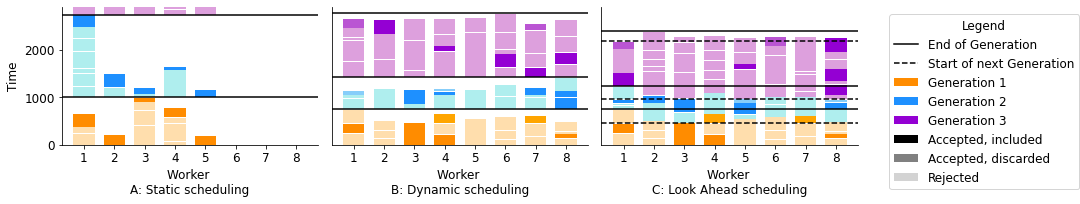

In [41]:
isPPP=False
draw_source=False

Nacceptances=5
Nworkers=8

fig, axes = plt.subplots(1,3, figsize=(15,3))

ax = axes[1]
generate_picture(ax, testdata_source, colordict, isPPP=False, draw_source=False,
                         Nacceptances=Nacceptances, Nworkers=Nworkers,
                         title = "B: Dynamic scheduling")
ax.set_ylabel(None)
ax.set_yticks([])

ymin,ymax=ax.get_ylim()
ymax=ymax*1.05
ax.set_ylim(ymin,ymax)

ax = axes[0]
generate_static(ax, testdata_source, colordict, isPPP=False, draw_source=False,
                         Nacceptances=Nacceptances, Nworkers=Nworkers, y_max=ymax, legend=False,
                         title = "A: Static scheduling")

ax = axes[2]
generate_picture(ax, testdata_source, colordict, isPPP=True, draw_source=False,
                         Nacceptances=Nacceptances, Nworkers=Nworkers, y_max=ymax, 
                         title = "C: Look Ahead scheduling")
ax.set_ylabel(None)
ax.set_yticks([])

l1 = axes[0].bar([1],[1],0, color = colordict['1Accepted'], label = "Generation 1")[0]
l2 = axes[0].bar([1],[1],0, color = colordict['2Accepted'], label = "Generation 2")[0]
l3 = axes[0].bar([1],[1],0, color = colordict['3Accepted'], label = "Generation 3")[0]
l4 = axes[0].bar([1],[1],0, color = 'black', label = "Accepted, included")[0]
l5 = axes[0].bar([1],[1],0, color = 'grey', label = "Accepted, discarded")[0]
l6 = axes[0].bar([1],[1],0, color = 'lightgrey', label = "Rejected")[0]

l7 = axes[0].plot([1],[1], color='black', label="End of generation")[0]
l8 = axes[0].plot([1],[1], color='black', linestyle='dashed', label="Start of generation")[0]

labels=["End of Generation", "Start of next Generation", 
        "Generation 1", "Generation 2", "Generation 3",
        "Accepted, included", "Accepted, discarded", "Rejected"]
# Create the legend
fig.legend([l7, l8, l1, l2, l3, l4, l5, l6],
           labels,
           loc="center right",
           borderaxespad=0.1,
           title="Legend")
fig.tight_layout()
plt.subplots_adjust(right=0.8)
plt.savefig(r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\SchedulingApproaches.pdf")

C:\Users\Felipe\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


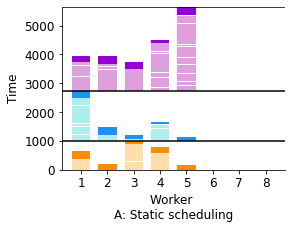

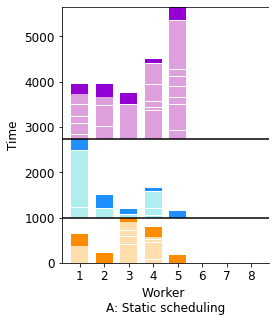

In [42]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
generate_static(ax, testdata_source, colordict, isPPP=False, draw_source=False,
                         Nacceptances=Nacceptances, Nworkers=Nworkers, legend=False,
                         title = "A: Static scheduling")
ymin_stat,ymax_stat=ax.get_ylim()

fig, ax = plt.subplots(1,1, figsize=(4,ymax_stat/(ymax*1.05)*2.5))
generate_static(ax, testdata_source, colordict, isPPP=False, draw_source=False,
                         Nacceptances=Nacceptances, Nworkers=Nworkers, legend=False,
                         title = "A: Static scheduling")
fig.tight_layout()

plt.savefig(r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\StaticSched.pdf")

C:\Users\Felipe\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


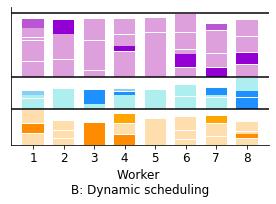

In [43]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
generate_picture(ax, testdata_source, colordict, isPPP=False, draw_source=False,
                         Nacceptances=Nacceptances, Nworkers=Nworkers,
                         title = "B: Dynamic scheduling")
ax.set_ylabel(None)
ax.set_yticks([])
ymin,ymax=ax.get_ylim()
ymax=ymax*1.05
ax.set_ylim(ymin,ymax)
fig.tight_layout()

plt.savefig(r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\DynamicSched.pdf")

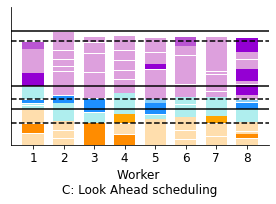

In [44]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
generate_picture(ax, testdata_source, colordict, isPPP=True, draw_source=False,
                         Nacceptances=Nacceptances, Nworkers=Nworkers, y_max=ymax, 
                         title = "C: Look Ahead scheduling")
ax.set_ylabel(None)
ax.set_yticks([])
fig.tight_layout()

plt.savefig(r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\LASched.pdf")

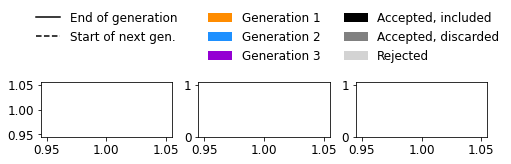

In [37]:
fig, axes = plt.subplots(1,3, figsize=(8,1))
l1 = axes[1].bar([1],[1],0, color = colordict['1Accepted'], label = "Generation 1")[0]
l2 = axes[1].bar([1],[1],0, color = colordict['2Accepted'], label = "Generation 2")[0]
l3 = axes[1].bar([1],[1],0, color = colordict['3Accepted'], label = "Generation 3")[0]
l4 = axes[2].bar([1],[1],0, color = 'black', label = "Accepted, included")[0]
l5 = axes[2].bar([1],[1],0, color = 'grey', label = "Accepted, discarded")[0]
l6 = axes[2].bar([1],[1],0, color = 'lightgrey', label = "Rejected")[0]

l7 = axes[0].plot([1],[1], color='black', label="End of generation")[0]
l8 = axes[0].plot([1],[1], color='black', linestyle='dashed', label="Start of generation")[0]

labels=["End of generation", "Start of next gen.", 
        "Generation 1", "Generation 2", "Generation 3",
        "Accepted, included", "Accepted, discarded", "Rejected"]
# Create the legend
axes[0].legend([l7,l8], labels[:2], loc = "upper center", bbox_to_anchor = (0.5, 2.5), frameon=False)
axes[1].legend([l1,l2,l3], labels[2:5], loc = "upper center", bbox_to_anchor = (0.5, 2.5), frameon=False)
axes[2].legend([l4,l5,l6], labels[5:8], loc = "upper center", bbox_to_anchor = (0.5, 2.5), frameon=False)
plt.savefig(r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\Legend.pdf")